# 1 Data overview

Let's have a quick glance at initial data

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import stats as st

Auxiliary function to simplify code reading

In [2]:
def read_and_describe(path, date_column=None):
    result = pd.read_csv(path, parse_dates=date_column)
       
    display(result.sample(2))
    print()
    
    result.info()
    
    return result

In [3]:
users = read_and_describe('users.csv', ['reg_date', 'churn_date'])

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
100,1100,58,NaT,Санкт-Петербург,Руслан,Красильников,2018-07-02,smart
266,1266,32,NaT,Калуга,Тала,Антропова,2018-07-20,smart



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [4]:
calls = read_and_describe('calls.csv', ['call_date'])

,id,call_date,duration,user_id
137735,1352_459,2018-08-08,13.84,1352
134196,1344_13,2018-08-06,2.33,1344



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [5]:
messages = read_and_describe('messages.csv', ['message_date'])

,id,message_date,user_id
92992,1382_453,2018-05-19,1382
106252,1430_327,2018-09-15,1430



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [6]:
sessions = read_and_describe('internet.csv', ['session_date'])

,Unnamed: 0,id,mb_used,session_date,user_id
134545,134545,1452_83,244.02,2018-09-05,1452
41477,41477,1145_213,0.00,2018-11-28,1145



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [7]:
tariffs = read_and_describe('tariffs.csv')

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


## 1.1 Section 1 conclusions:

- Input tables do have missing values
- 38 out 500 values in users['churn_date'] means that the tariff was still in effect at the moment of data upload for other 462 users
- Data columns are loaded correctly

# 2 Data preprocessing

At this stage we need to calculate for each user the number of messages, MB of Internet and time of calls for the reporting period - month

And again let's add one more auxiliary function to simplify code

In [8]:
def spending_pr_month(df, date_column, agg_column, agg_func):
    
    # add a column with the month attribute because we have source data for 2018 only
    df['month'] = df[date_column].dt.month
    print('Initial dataframe + month column')
    display(df.sample(3))
    print('\n')
    
    df_per_month = df.groupby(by=['user_id','month']).agg({agg_column: agg_func})
    print('Aggregated by user and month')
    display(df_per_month.sample(5))
    
    return df_per_month

## 2.1 Table "Calls"

Let's see the distiribution of calls by duration (mins)

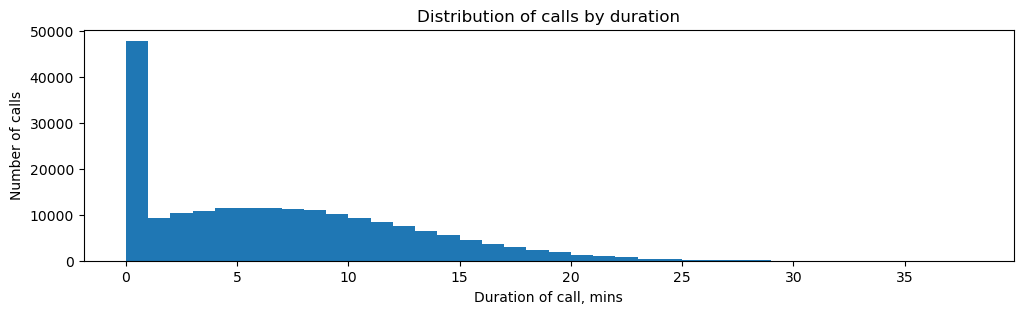

In [9]:
plt.figure(figsize=(12, 3))

calls['duration'].hist(bins=int(calls['duration'].max()))

# Add axis names and the chart title
plt.xlabel('Duration of call, mins')
plt.ylabel('Number of calls')
plt.title('Distribution of calls by duration')

plt.grid(False)

plt.show()

In [10]:
calls['duration'].value_counts()

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
26.94        1
32.19        1
26.32        1
27.41        1
26.90        1
Name: duration, Length: 2871, dtype: int64

- There are calls with zero duration. This is not an error: the zeros represent missed calls, so we will not remove them
- The **duration** column of the **calls** dataframe has fractional values. Since **payment is based on minutes**, round the duration column values up using the numpy.ceil() method and convert the duration column to int type

In [11]:
calls['duration'] = np.ceil(calls['duration']).astype('int')

In [12]:
minutes_per_month = spending_pr_month(calls, 'call_date', 'duration', 'sum')

Initial dataframe + month column


,id,call_date,duration,user_id,month
156673,1386_188,2018-12-24,0,1386,12
133362,1341_592,2018-08-15,11,1341,8
85307,1213_353,2018-10-22,0,1213,10




Aggregated by user and month


,,duration
user_id,month,
1404,12,133
1340,8,479
1433,7,503
1419,11,456
1089,10,523


## 2.2 Messages

In [13]:
messages_per_month = spending_pr_month(messages, 'message_date', 'message_date', 'count')

Initial dataframe + month column


,id,message_date,user_id,month
113535,1460_216,2018-07-27,1460,7
56403,1250_227,2018-10-23,1250,10
104082,1423_415,2018-08-14,1423,8




Aggregated by user and month


,,message_date
user_id,month,
1035,10,53
1473,12,20
1464,5,21
1407,11,28
1186,10,46


## 2.3 Sessions

Let's remove the ***Unnamed: 0*** column from the sessions dataframe. It will not be needed for further work.

In [14]:
sessions = sessions.drop(columns=['Unnamed: 0'])

In [15]:
sessions_per_month = spending_pr_month(sessions, 'session_date', 'mb_used', 'sum')

Initial dataframe + month column


,id,mb_used,session_date,user_id,month
50540,1173_189,0.00,2018-07-06,1173,7
34502,1120_74,1364.77,2018-04-05,1120,4
46020,1157_532,230.28,2018-06-24,1157,6




Aggregated by user and month


,,mb_used
user_id,month,
1253,11,16150.10
1321,3,13945.68
1083,7,17199.33
1284,4,15289.70
1324,9,23537.25


# 3 Consolidation of user data and tariffs' comparison

## 3.1 Consolidation of user data

Combine all the values calculated above into one **user_behavior** dataframe. For each "user-month" pair, information about tariff, number of calls, messages and spent megabytes will be available

In [16]:
user_behavior = minutes_per_month\
    .merge(messages_per_month, left_index=True, right_index=True, how='outer')\
    .merge(sessions_per_month, left_index=True, right_index=True, how='outer')\
    .reset_index()\
    .merge(users, how='left', left_on='user_id', right_on='user_id')\

user_behavior.sample(5)

,user_id,month,duration,message_date,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
198,1031,11,665.0,25.0,11290.07,66,NaT,Москва,Лаврентий,Тимофеев,2018-11-02,smart
747,1118,3,547.0,NaN,10785.46,65,NaT,Казань,Вера,Латышева,2018-03-06,smart
2010,1317,12,709.0,34.0,13291.87,45,NaT,Москва,Всеволод,Зыков,2018-07-09,smart
2447,1383,12,285.0,9.0,10032.34,41,NaT,Ульяновск,Юна,Сомова,2018-10-24,smart
3018,1469,12,635.0,NaN,27762.83,41,NaT,Сочи,Аксён,Абалкин,2018-07-06,ultra


Rename columns for convenience 

In [17]:
user_behavior = user_behavior.rename(columns={'duration': 'minutes', 'message_date': 'messages'})

user_behavior.sample(5)

,user_id,month,minutes,messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
500,1079,11,560.0,33.0,7901.96,20,NaT,Москва,Еремей,Авроров,2018-05-15,smart
2751,1428,9,414.0,NaN,22313.42,42,NaT,Новосибирск,Камилла,Добрынина,2018-08-25,smart
2507,1392,9,377.0,38.0,21730.26,54,2018-09-27,Челябинск,Алла,Беликова,2018-02-27,ultra
431,1067,7,383.0,63.0,5774.90,45,NaT,Москва,Юзефа,Абашкина,2018-04-09,smart
2133,1337,4,197.0,11.0,23590.76,42,NaT,Вологда,Олег,Суслов,2018-01-15,smart


Let's determine the number of rows after merging

In [18]:
len(user_behavior)

3214

Let's check the gaps in the `user_behavior` dataframe after the merge:

In [19]:
user_behavior.isna().sum()

user_id          0
month            0
minutes         40
messages       497
mb_used         11
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

Let's fill in the gaps in the data, considering them as absence of calls, sending messages or internet services

In [20]:
user_behavior['minutes'] = user_behavior['minutes'].fillna(0)
user_behavior['messages'] = user_behavior['messages'].fillna(0)
user_behavior['mb_used'] = user_behavior['mb_used'].fillna(0)

Let's add information about the tariffs

In [21]:
# rename the **tariff_name** column to a simpler one: **tariff**

tariffs = tariffs.rename( columns={'tariff_name': 'tariff'} )
user_behavior = user_behavior.merge(tariffs, on='tariff')
user_behavior.sample(3)

,user_id,month,minutes,messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
2240,1275,5,348.0,28.0,18692.93,48,NaT,Москва,Семён,Елизаров,2018-04-24,smart,50,15360,500,550,200,3,3
1828,1179,7,579.0,0.0,11467.51,43,NaT,Вологда,Дана,Астапенко,2018-04-19,smart,50,15360,500,550,200,3,3
2054,1228,9,428.0,0.0,11460.21,28,NaT,Нижний Новгород,Денис,Алфимов,2018-04-17,smart,50,15360,500,550,200,3,3


Count the number of talk minutes, messages and megabytes in surplus to those included in the tariff. If there are no excesses, we keep 0

In [22]:
user_behavior['paid_minutes'] = user_behavior['minutes'] - user_behavior['minutes_included']
user_behavior['paid_messages'] = user_behavior['messages'] - user_behavior['messages_included']
user_behavior['paid_mb'] = user_behavior['mb_used'] - user_behavior['mb_per_month_included']

for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0

Convert megabytes exceeding the tariff into gigabytes and save them in the `paid_gb` column

In [23]:
user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)

Calculate revenue per minutes of calls, messaging and internet services

In [24]:
user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * user_behavior['rub_per_minute']
user_behavior['cost_messages'] = user_behavior['paid_messages'] * user_behavior['rub_per_message']
user_behavior['cost_gb'] = user_behavior['paid_gb'] * user_behavior['rub_per_gb']

Calculate the monthly revenue from each user, it will be stored in the `total_cost` column

In [25]:
user_behavior['total_cost'] = user_behavior['rub_monthly_fee'] + user_behavior['cost_minutes']\
    + user_behavior['cost_messages'] + user_behavior['cost_gb']

## 3.2 Tariffs' comparison

When analyzing, let's not forget the disparity of data between tariffs by a factor of 2.3

In [26]:
user_behavior['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

Let's save basic characteristics in the `stats_df` dataframe for each "month-rate" pair

In [27]:
stats_df = user_behavior.pivot_table( index=['month', 'tariff'], values=['minutes', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']).round(2).reset_index()

stats_df.columns=['month', 'tariff', 'mb_used_mean', 'messages_mean', 'minutes_mean',
                                     'mb_used_std', 'messages_std', 'minutes_std', 
                                     'mb_used_median', 'messages_median',  'minutes_median']

stats_df.sample(7)

,month,tariff,mb_used_mean,messages_mean,minutes_mean,mb_used_std,messages_std,minutes_std,mb_used_median,messages_median,minutes_median
14,8,smart,16610.72,33.64,421.47,5593.50,28.95,186.53,16833.49,27.0,432.0
2,2,smart,11597.05,24.09,298.69,6247.35,21.75,190.82,12553.71,20.0,258.0
18,10,smart,16757.12,33.77,426.14,5859.38,28.57,188.13,17225.34,30.0,427.5
17,9,ultra,19204.28,52.29,539.44,9486.09,46.40,325.14,19656.30,43.0,520.0
19,10,ultra,20045.34,58.43,558.08,9803.11,51.93,326.29,20338.15,49.0,533.0
10,6,smart,15794.65,33.40,395.64,5791.16,28.40,175.34,16077.44,28.0,400.0
11,6,ultra,18924.94,41.73,479.70,9292.88,44.57,302.55,19480.21,27.5,479.0


And again let's add one more auxiliary function to simplify code

In [28]:
def charts_for_tariffs(data, item, binwidth):
    
    # The first chart
    plt.figure(figsize=(15, 3))
    
    y = item + '_mean'
    ax = sns.barplot(x='month', y=y, hue="tariff", data=data, palette=['lightgrey', 'lightgreen'])

    ax.set_title('Distribution of average ' + item + ' by tariff type and month')
    ax.set(xlabel='Month', ylabel='Average ' + item)
    
    plt.legend(loc='lower right')

    plt.show()
    
    
    # The second chart
    plt.figure(figsize=(15, 3))
    
    ax1 = sns.histplot(data=user_behavior[user_behavior['tariff'] =='smart'][item],\
                       binwidth=binwidth, alpha=0.6, color='lightgrey', label='smart', stat='percent', edgecolor="white")
    
    ax1 = sns.histplot(data=user_behavior[user_behavior['tariff'] =='ultra'][item],\
                       binwidth=binwidth, alpha=0.6, color='lightgreen', label='ultra', stat='percent', edgecolor="white")
    
    ax1.set_title('Distribution of ' + item + ' by tariff type and pairs "user-month" (relative values)')
    ax1.set(xlabel=item, ylabel='% of pairs "user-month"')


    plt.grid(False)

    plt.legend()

    plt.show()

### 3.2.1 Comparison of spent minutes among Smart and Ultra tariff users

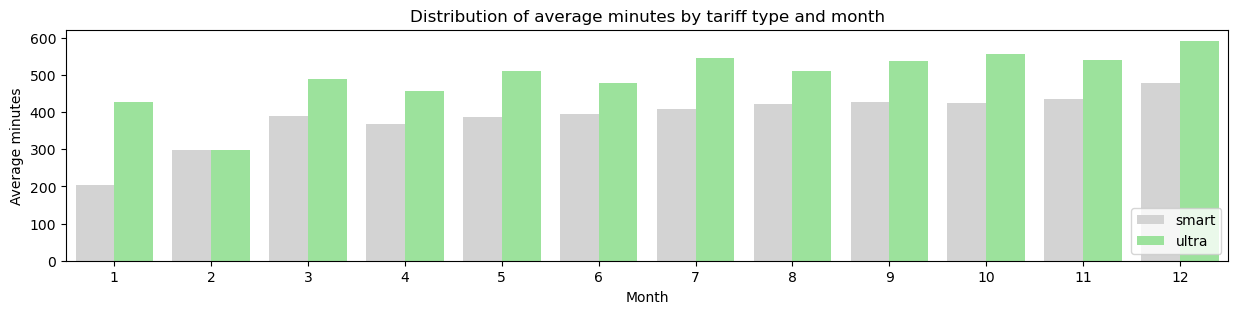

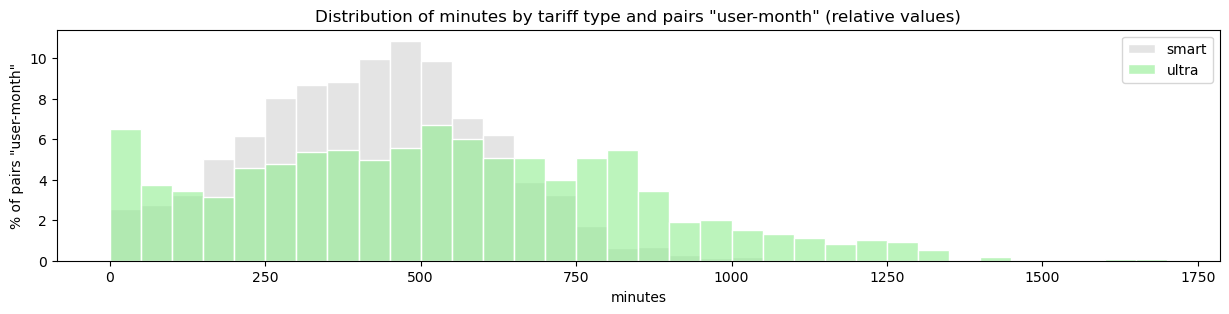

In [29]:
charts_for_tariffs(stats_df, 'minutes', 50)

Comments on the charts:

- the first chart:
    - users of both tariffs increase the average call duration from January to December;
    - the average call duration of for Ultra tariff subscribers is longer than for Smart tariff subscribers;
    - subscribers of both tariff plans had the lowest rates in February (it might be caused by the least number of days)
    
    
- the second chart:
    - for **smart** tariff users, we see that the distribution of call minutes during the month is unimodal with a peak around 450-500 minutes, concentrated in the segment 0 - 800;
    - for **ultra** tariff users, we see that the distribution of minutes for calls during the month is tri-modal with peaks around 0, 500-550, 800-850 minutes, concentrated in the segment 0 - 1350.

### 3.2.2 Comparison of spent messages among Smart and Ultra tariff users

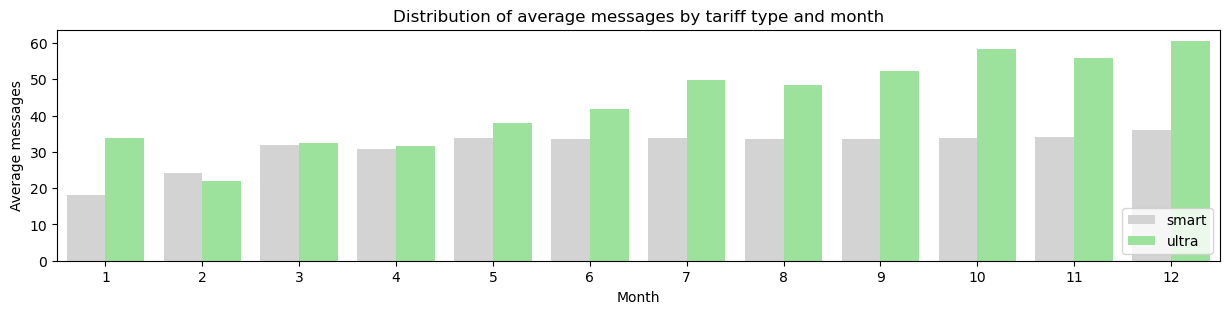

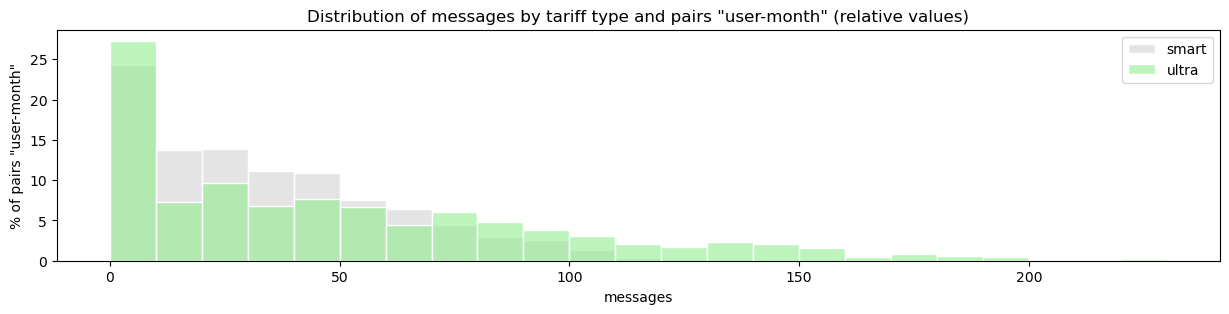

In [30]:
charts_for_tariffs(stats_df, 'messages', 10)

Comments on the charts:

- the first chart:
    - **ultra** tariff users increased the average message number in about 2 times from January to December;
    - **smart** tariff users had plato between 31-36 messages per month since March;
    
    
- the second chart:
    - 24%-27% pairs "user-month" of **smart** and **ultra** tariffs had less than 10 messages per month.

### 3.2.3 Comparison of spent gigabytes among Smart and Ultra tariff users

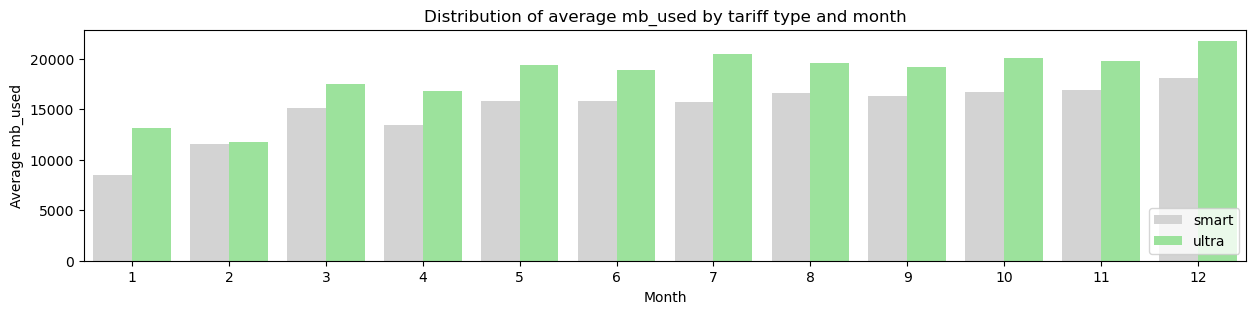

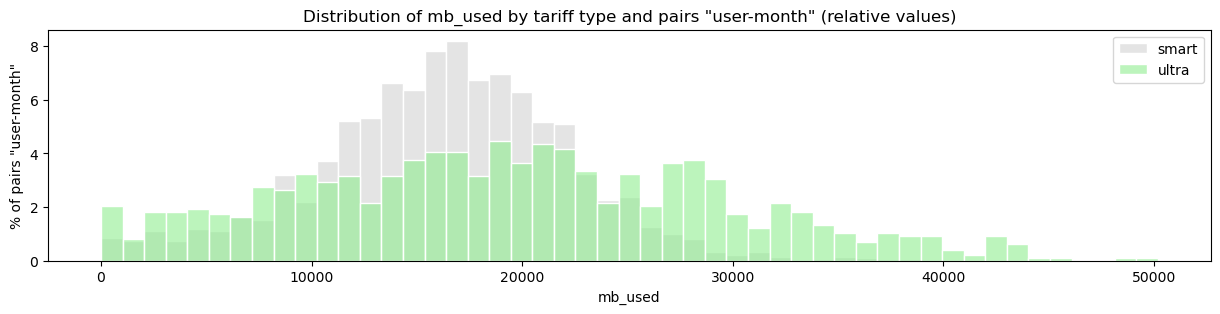

In [31]:
charts_for_tariffs(stats_df, 'mb_used', 1024)

Comments on the charts:

- the first chart:
    - **ultra** tariff users increased the average monthly internet consuming by near 50% from January to December;
    - **smart** tariff users also increased the average internet consuming by near 100%;
    
    
- the second chart:
    - The distribution of **spent Internet traffic** is similar to the distribution of minutes: **ultra** tariff users had a multimodal distribution over a wide segment (0-34 GB), while **smart** tariff users had a marked unimodal distribution over a narrower segment (0-29 GB).

# 4 Statistical hypothesis testing

Let's describe an auxiliary function to simplify code in this section

In [32]:
def testing(df_1, df_2, alpha):
    
    # alpha = set significance level value
    
    results = st.ttest_ind(df_1, df_2, equal_var=False)

    # p-value output
    print('p-value: {0}\n'.format(results.pvalue))
    
    # Сonditional operator with the output of the answer whether the null hypothesis is true or not
    if results.pvalue < alpha:
        print('Rejecting the null hypothesis')
    else:
        print('Failed to reject the null hypothesis')

## 4.1 Hypothesis testing: average revenue of **"ultra"** and **"smart"** users are different;

    H_0: Revenue (total_cost) of "ultra" users = revenue (total_cost) of "smart" users
    H_1: Revenue (total_cost) of "ultra" users ≠ revenue (total_cost) of "smart" users

In [33]:
ultra_set = user_behavior[user_behavior['tariff'] == 'ultra']['total_cost']
smart_set = user_behavior[user_behavior['tariff'] == 'smart']['total_cost']

testing(ultra_set, smart_set, 0.05)

p-value: 4.2606313931076085e-250

Rejecting the null hypothesis


## 4.2 Hypothesis testing: users from Moscow bring more revenue than users from other cities;

    H_0: Revenue (total_cost) of Moscow users = revenue (total_cost) of non-Moscow users
    H_1: Revenue (total_cost) of Moscow users ≠ revenue (total_cost) of non-Moscow users

In [34]:
moscow_subset = user_behavior[user_behavior['city'] == 'Москва']['total_cost']
other_subset = user_behavior[user_behavior['city'] != 'Москва']['total_cost']

testing(moscow_subset, other_subset, 0.05)

p-value: 0.5257376663729298

Failed to reject the null hypothesis
